# Best Random Forest Model

The bias is the same as the baseline model.

model_1536387410 - results.txt:
- Data: year=2014, month=01-01, size=mid
- Time (in seconds): 87767 = 24h22m
- [('maxDepth', 30), ('minInstancesPerNode', 1), ('numTrees', 300)] - 0.0331134166639611 -

In [1]:
import pyspark
from pyspark.ml import PipelineModel
from utils import sparkutils, modelutils

import matplotlib
import matplotlib.pyplot as plt

In [2]:
spark = pyspark.sql.SparkSession.builder\
.appName("Rides Preprocessor")\
.master("local")\
.config("spark.local.dir", "/home/atkm/nycTaxi/tmp")\
.config("spark.driver.memory", "4g")\
.getOrCreate()

In [6]:
def get_ride_data(year, month, size='tiny'):
    return f'data/yellow_tripdata_{year}-{month:02}_{size}.csv'

def get_metar_data(year, month):
    return f'data/metar_data/lga_{year}-{month:02}.csv'

def read_csv(path):
    return spark.read.format("csv")\
      .option("header", "true")\
      .option("inferSchema", "true")\
      .load(path)

def load_metar(metarPath):
    metar = read_csv(metarPath)
    metar = metar.select("valid","tmpf", " p01i") # note whitespace in p01i
    return metar.withColumnRenamed('valid', 'datetime')\
        .withColumnRenamed('tmpf', 'fahrenheit')\
        .withColumnRenamed(' p01i', 'precip_in')

def load_rides(ridesPath):
    rides = read_csv(ridesPath)
    # 2015
    if 'tpep_pickup_datetime' in rides.schema.names:
        rides = rides.withColumnRenamed('tpep_pickup_datetime', 'pickup_datetime')
    # 2014
    colNames = map(lambda name: name.strip(), rides.columns)
    rides = rides.toDF(*colNames)
    return rides.select("pickup_datetime","pickup_latitude", "pickup_longitude")


## Trained on 2014-02 small; test on 2015-02

In [4]:
with open('training_results/rfmodel_1536805228/results.txt') as f:
    print(f.read())

Data: train year=2014, test/dev year=2015, size=small
Time (in seconds): 42626
 = 11h50m
[('minInstancesPerNode', 1), ('numTrees', 100), ('maxDepth', 30)] - 0.03325313688414613 - 
Test rmse: 0.03956585522445218



In [5]:
model = PipelineModel.load('training_results/rfmodel_1536387410/rfmodel_1536387410.model/')

AnalysisException: "cannot resolve '`pickup_datetime`' given input columns: [payment_type, fare_amount, mta_tax, trip_distance, dropoff_longitude, tip_amount, dropoff_latitude, total_amount, tpep_pickup_datetime, tolls_amount, store_and_fwd_flag, pickup_longitude, pickup_latitude, tpep_dropoff_datetime, VendorID, improvement_surcharge, RateCodeID, passenger_count, extra];;\n'Project ['pickup_datetime, pickup_latitude#84, pickup_longitude#83]\n+- AnalysisBarrier\n      +- Project [VendorID#40 AS VendorID#78, tpep_pickup_datetime#41 AS tpep_pickup_datetime#79, tpep_dropoff_datetime#42 AS tpep_dropoff_datetime#80, passenger_count#43 AS passenger_count#81, trip_distance#44 AS trip_distance#82, pickup_longitude#45 AS pickup_longitude#83, pickup_latitude#46 AS pickup_latitude#84, RateCodeID#47 AS RateCodeID#85, store_and_fwd_flag#48 AS store_and_fwd_flag#86, dropoff_longitude#49 AS dropoff_longitude#87, dropoff_latitude#50 AS dropoff_latitude#88, payment_type#51 AS payment_type#89, fare_amount#52 AS fare_amount#90, extra#53 AS extra#91, mta_tax#54 AS mta_tax#92, tip_amount#55 AS tip_amount#93, tolls_amount#56 AS tolls_amount#94, improvement_surcharge#57 AS improvement_surcharge#95, total_amount#58 AS total_amount#96]\n         +- Relation[VendorID#40,tpep_pickup_datetime#41,tpep_dropoff_datetime#42,passenger_count#43,trip_distance#44,pickup_longitude#45,pickup_latitude#46,RateCodeID#47,store_and_fwd_flag#48,dropoff_longitude#49,dropoff_latitude#50,payment_type#51,fare_amount#52,extra#53,mta_tax#54,tip_amount#55,tolls_amount#56,improvement_surcharge#57,total_amount#58] csv\n"

In [8]:
rides = sparkutils.count_rides(
    load_rides(get_ride_data(2015,2,'small'))
)
metar = sparkutils.clean_metar(
    load_metar(get_metar_data(2015,2))
)
joined = sparkutils.join_rides_metar(rides,metar)

In [9]:
%%time
pred = model.transform(joined)

CPU times: user 22.2 ms, sys: 2.04 ms, total: 24.3 ms
Wall time: 31.9 s


In [10]:
df = pred.select('grid_x','grid_y','count_scaled','fahrenheit','precip_in','weekday','hour','prediction').toPandas()
df['residual'] = df['prediction'] - df['count_scaled']
df.head()

,grid_x,grid_y,count_scaled,fahrenheit,precip_in,weekday,hour,prediction,residual
0,23,39,0.015873,21.92,0.0,4,5,0.015906,0.000033
1,3,28,0.015873,21.92,0.0,4,5,0.039944,0.024071
2,4,28,0.055556,21.92,0.0,4,5,0.057281,0.001725
3,6,23,0.007937,21.92,0.0,4,5,0.028529,0.020593
4,4,26,0.039683,21.92,0.0,4,5,0.055451,0.015768


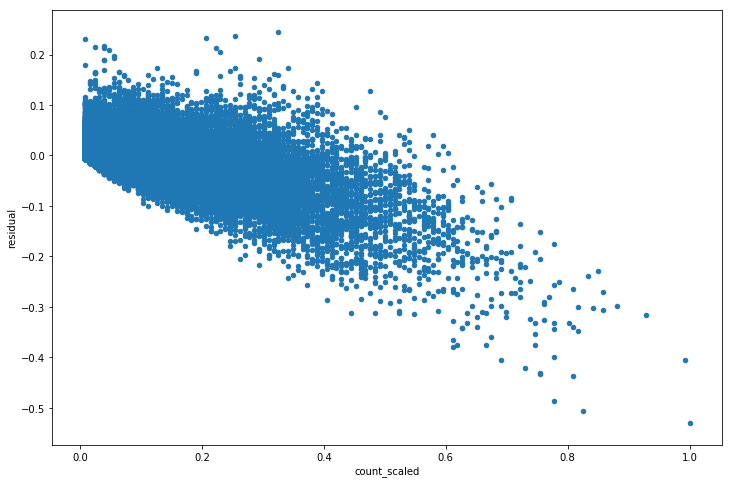

In [11]:
fig, ax = plt.subplots(figsize=(12,8))
df.plot.scatter('count_scaled', 'residual', ax=ax)

In [17]:
print('scaled RMSE: ', modelutils.rmse(df['count_scaled'], df['prediction']), end='\n\n')
print('Residual stats: ', df.residual.describe())

scaled RMSE:  0.041826952672794036

Residual stats:  count    48530.000000
mean        -0.004084
std          0.041628
min         -0.529135
25%         -0.011278
50%         -0.002337
75%          0.011620
max          0.243937
Name: residual, dtype: float64


## Trained on 2014-01-mid

In [1]:
with open('training_results/rfmodel_1536387410/results.txt') as f:
    print(f.read())

Data: year=2014, month=01-01, size=mid
Time (in seconds): 87767
 = 24h22m
[('maxDepth', 30), ('minInstancesPerNode', 1), ('numTrees', 100)] - 0.03336056792436286 - 
[('maxDepth', 30), ('minInstancesPerNode', 1), ('numTrees', 200)] - 0.0331431586764398 - 
[('maxDepth', 30), ('minInstancesPerNode', 1), ('numTrees', 300)] - 0.0331134166639611 - 
[('maxDepth', 30), ('minInstancesPerNode', 5), ('numTrees', 100)] - 0.03670034700200661 - 
[('maxDepth', 30), ('minInstancesPerNode', 5), ('numTrees', 200)] - 0.036668744556606556 - 
[('maxDepth', 30), ('minInstancesPerNode', 5), ('numTrees', 300)] - 0.03692346887293368 - 
Test rmse: 0.030172121767087324



In [5]:
model = PipelineModel.load('training_results/rfmodel_1536387410/rfmodel_1536387410.model/')

In [6]:
rf_pmap = model.stages[1]
rf_pmap.getParam('numTrees')

Param(parent='RandomForestRegressor_4ac0ba16b695c1095c59', name='numTrees', doc='Number of trees to train (>= 1)')

In [7]:
rides = sparkutils.count_rides(
    load_rides(get_ride_data(2014,2,'small'))
)
metar = sparkutils.clean_metar(
    load_metar(get_metar_data(2014,2))
)
joined = sparkutils.join_rides_metar(rides,metar)

In [8]:
pred = model.transform(joined)

In [9]:
pred.count()

48801

In [10]:
pred.select('grid_x','grid_y','count_scaled','fahrenheit','precip_in','weekday','hour','prediction').show(5)

+------+------+--------------------+----------+---------+-------+----+--------------------+
|grid_x|grid_y|        count_scaled|fahrenheit|precip_in|weekday|hour|          prediction|
+------+------+--------------------+----------+---------+-------+----+--------------------+
|     5|    33| 0.02158273381294964|      32.0|      0.0|      2|  19|0.011351272672355394|
|     4|    32|0.007194244604316547|      32.0|      0.0|      2|  19|0.007173798548970301|
|     6|    29| 0.03597122302158273|      32.0|      0.0|      2|  19|0.042052977138908564|
|     5|    32| 0.02158273381294964|      32.0|      0.0|      2|  19|0.007699720491528302|
|     7|    31|0.007194244604316547|      32.0|      0.0|      2|  19|0.014312780024728643|
+------+------+--------------------+----------+---------+-------+----+--------------------+
only showing top 5 rows



In [11]:
df = pred.select('grid_x','grid_y','count_scaled','fahrenheit','precip_in','weekday','hour','prediction').toPandas()

In [12]:
df.head()

,grid_x,grid_y,count_scaled,fahrenheit,precip_in,weekday,hour,prediction
0,5,33,0.021583,32.0,0.0,2,19,0.011351
1,4,32,0.007194,32.0,0.0,2,19,0.007174
2,6,29,0.035971,32.0,0.0,2,19,0.042053
3,5,32,0.021583,32.0,0.0,2,19,0.007700
4,7,31,0.007194,32.0,0.0,2,19,0.014313


In [13]:
df['residual'] = df['prediction'] - df['count_scaled']

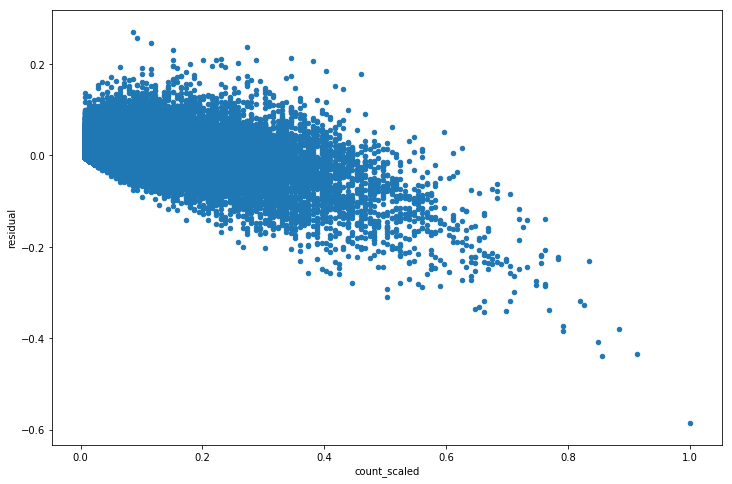

In [14]:
fig, ax = plt.subplots(figsize=(12,8))
df.plot.scatter('count_scaled', 'residual', ax=ax)